- `conda activate mri`
  - (created in `0_setup.ipynb`)

---

- `jupyter lab` => open this file

---

- Selected Jupyter kernel (`ms_classification`)
  - (created in `0_setup.ipynb`)

---

---

Evaluate how mis‐specified calibration populations affect empirical coverage and prediction set sizes

---

# Imports & Definitions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(
    context='paper',
    style='whitegrid',
    font_scale=1.2,
    rc={
        'figure.dpi': 300,
        'savefig.dpi': 600,
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans']
    }
)
sns.set_palette('colorblind')

# long to wide format
def summary_to_wide(agg):
    # 1) sanity-check: class_conditional must be uniform
    if agg['class_conditional'].nunique() != 1:
        raise ValueError(
            "Input must have class_conditional uniformly True or uniformly False"
        )
    is_conditional = bool(agg['class_conditional'].iloc[0])
    
    # --- pick grouping columns based on that flag ---
    grp_cols = ['class_conditional', 'cal_test', 'variant_test_data'] 
    grp_cols += (['class'] if is_conditional else [])
        
    agg_wide = (
        agg
          .pivot_table(index=grp_cols,
                       columns='statistic',
                       values='p_value')
          .reset_index()
    )
    # flatten the column index created by pivot_table
    agg_wide.columns.name = None
    return agg_wide

def style(df):
    def smart_fmt(x):
        # format to two decimals…
        s = f"{x:.2f}"
        # …but if x is nonzero and  would display as “0.00”, use scientific notation
        if x != 0 and s == "0.00":
            return f"{x:.1e}"
        else:
            return s    
    cols = ['median_cov', 'binom_p', 'fisher_p', 'prop_sig', 'q25_p', 'median_p', 'q75_p']
    return df.style.format({c: smart_fmt for c in cols})

def get_stats(df_runs: pd.DataFrame,
              df_summary: pd.DataFrame) -> pd.DataFrame:
    """
    Compute median coverage + summary stats for one facet (either class_conditional=True or False).

    Parameters
    ----------
    df_runs : pd.DataFrame
        Must contain columns ['class_conditional','cal_test','variant_test_data','coverage', ...].
    df_summary : pd.DataFrame
        Must contain a matching 'class_conditional' column and be suitable for summary_to_wide().

    Returns
    -------
    pd.DataFrame
        Columns ['class_conditional','cal_test','variant_test_data',
                 'median_cov','binom_p','fisher_p','prop_sig',
                 'q25_p','median_p','q75_p'].
    """
    # --- 1) check that each DF is all-True or all-False, and they agree ---
    runs_flags    = set(df_runs['class_conditional'])
    summary_flags = set(df_summary['class_conditional'])

    valid = ({True}, {False})
    if runs_flags not in valid or summary_flags not in valid:
        raise ValueError(
            "Each input must have class_conditional uniformly True or uniformly False"
        )
    if runs_flags != summary_flags:
        raise ValueError(
            "df_runs and df_summary must agree on the value of class_conditional"
        )

    # pull out the boolean
    is_conditional = runs_flags.pop()

    # --- 2) pick grouping columns based on that flag ---
    grp_cols = ['class_conditional', 'cal_test', 'variant_test_data']
    if is_conditional:
        grp_cols.append('class')

    # --- 3a) median coverage from raw runs ---
    summary_runs = (
        df_runs
        .groupby(grp_cols)['coverage']
        .median()
        .reset_index()
        .rename(columns={'coverage': 'median_cov'})
    )

    # --- 3b) pivot & median on summary stats ---
    wide = summary_to_wide(df_summary)
    summary_stats = (
        wide
        .groupby(grp_cols)
        .median()
        .reset_index()
    )

    # --- 3c) merge & pick final column order ---
    cols = [
        'class_conditional', 'cal_test', 'variant_test_data',
        'median_cov', 'binom_p', 'fisher_p', 'prop_sig',
        'q25_p', 'median_p', 'q75_p'
    ] + (['class'] if is_conditional else [])
    
    result = (
        summary_runs
        .merge(summary_stats, on=grp_cols)
        [cols]
    )

    return result

runs = pd.read_csv(   'conformal_measures__runs__marginal.csv')
runs_cc = pd.read_csv(   'conformal_measures__runs__class_conditional.csv')
runs_cc_by_class = pd.read_csv(   'conformal_measures__runs__class_conditional__by_class.csv')

def plot_cov():
    df = runs[runs.cal_test.isin(['baseline3T-cal_dv1.5T-test', 'dv1.5T-cal_dv1.5T-test'])]
    g = sns.catplot(data=df, col='cal_test', x='verdict', hue='variant_test_data', kind='box', height=6, aspect=1.5)
    for ax in g.axes.flatten():
        ax.axvline(0.9, color='red', linestyle='--', linewidth=1)
    g.set_xlabels("Coverage")
    g.fig.suptitle("Coverage - 100 Experiments\nMismatched vs Matched", y=1.03, fontsize='20')
    g.fig.subplots_adjust(top=0.85)

def plot_cc_cov():
    df = runs_cc[runs_cc.cal_test.isin(['baseline3T-cal_dv1.5T-test', 'dv1.5T-cal_dv1.5T-test'])]
    g = sns.catplot(data=df, col='cal_test', x='verdict', hue='variant_test_data', kind='box', height=6, aspect=1.5)
    for ax in g.axes.flatten():
        ax.axvline(0.9, color='red', linestyle='--', linewidth=1)
    g.set_xlabels("Coverage")
    g.fig.suptitle("Class-Conditional Coverage - 100 Experiments\nMismatched vs Matched", y=1.03, fontsize='20')
    g.fig.subplots_adjust(top=0.85)

def plot_cc_cov_by_class():
    df = runs_cc_by_class[runs_cc_by_class.cal_test.isin(['baseline3T-cal_dv1.5T-test', 'dv1.5T-cal_dv1.5T-test'])]
    g = sns.catplot(data=df, col='cal_test', row='class', x='verdict', hue='variant_test_data', kind='box', height=6, aspect=1.5)
    for ax in g.axes.flatten():
        ax.axvline(0.9, color='red', linestyle='--', linewidth=1)
    g.set_xlabels("Coverage")
    g.fig.suptitle("Class-Conditional Coverage - 100 Experiments\nMismatched vs Matched\nBy Class", y=1.03, fontsize='20')
    g.fig.subplots_adjust(top=0.92)

---

# Read in Results

In [2]:
# --- read in all 8 tables ---
df_runs_scn_lvl    = pd.read_csv('conformal_coverage_guarantees__runs__scan_level.csv')
df_runs_scn_lvl_cc = pd.read_csv('conformal_coverage_guarantees__runs__scan_level__class_conditional.csv')
df_summary_scn_lvl    = pd.read_csv('conformal_coverage_guarantees__summary__scan_level.csv')
df_summary_scn_lvl_cc = pd.read_csv('conformal_coverage_guarantees__summary__scan_level__class_conditional.csv')

df_runs_slc_lvl    = pd.read_csv('conformal_coverage_guarantees__runs__slice_level.csv')
df_runs_slc_lvl_cc = pd.read_csv('conformal_coverage_guarantees__runs__slice_level__class_conditional.csv')
df_summary_slc_lvl    = pd.read_csv('conformal_coverage_guarantees__summary__slice_level.csv')
df_summary_slc_lvl_cc = pd.read_csv('conformal_coverage_guarantees__summary__slice_level__class_conditional.csv')

# --- add class_conditional flag and standardize variant_test_data (drop leading/trailing underscores) ---
for df, flag in [
    (df_runs_scn_lvl,    False),
    (df_summary_scn_lvl, False),
    (df_runs_scn_lvl_cc,    True),
    (df_summary_scn_lvl_cc, True),
    (df_runs_slc_lvl,    False),
    (df_summary_slc_lvl, False),
    (df_runs_slc_lvl_cc,    True),
    (df_summary_slc_lvl_cc, True),
]:
    df['class_conditional'] = flag
    df['variant_test_data'] = df['variant_test_data'].str.strip('_')

---

# Impact of Calibration–Test Distribution Shifts on Conformal Prediction Coverage

**Key Takeaway:**  
When future (test) patient data systematically differs from previously observed (calibration) data, the core assumptions that underlie conformal prediction’s coverage guarantees are violated.

> **Example:**  
> If calibration and test sets come from different underlying distributions—such as varying MRI scanner field strengths or other data variants—those assumption violations often manifest as visible coverage deficiencies and increased variance.

---

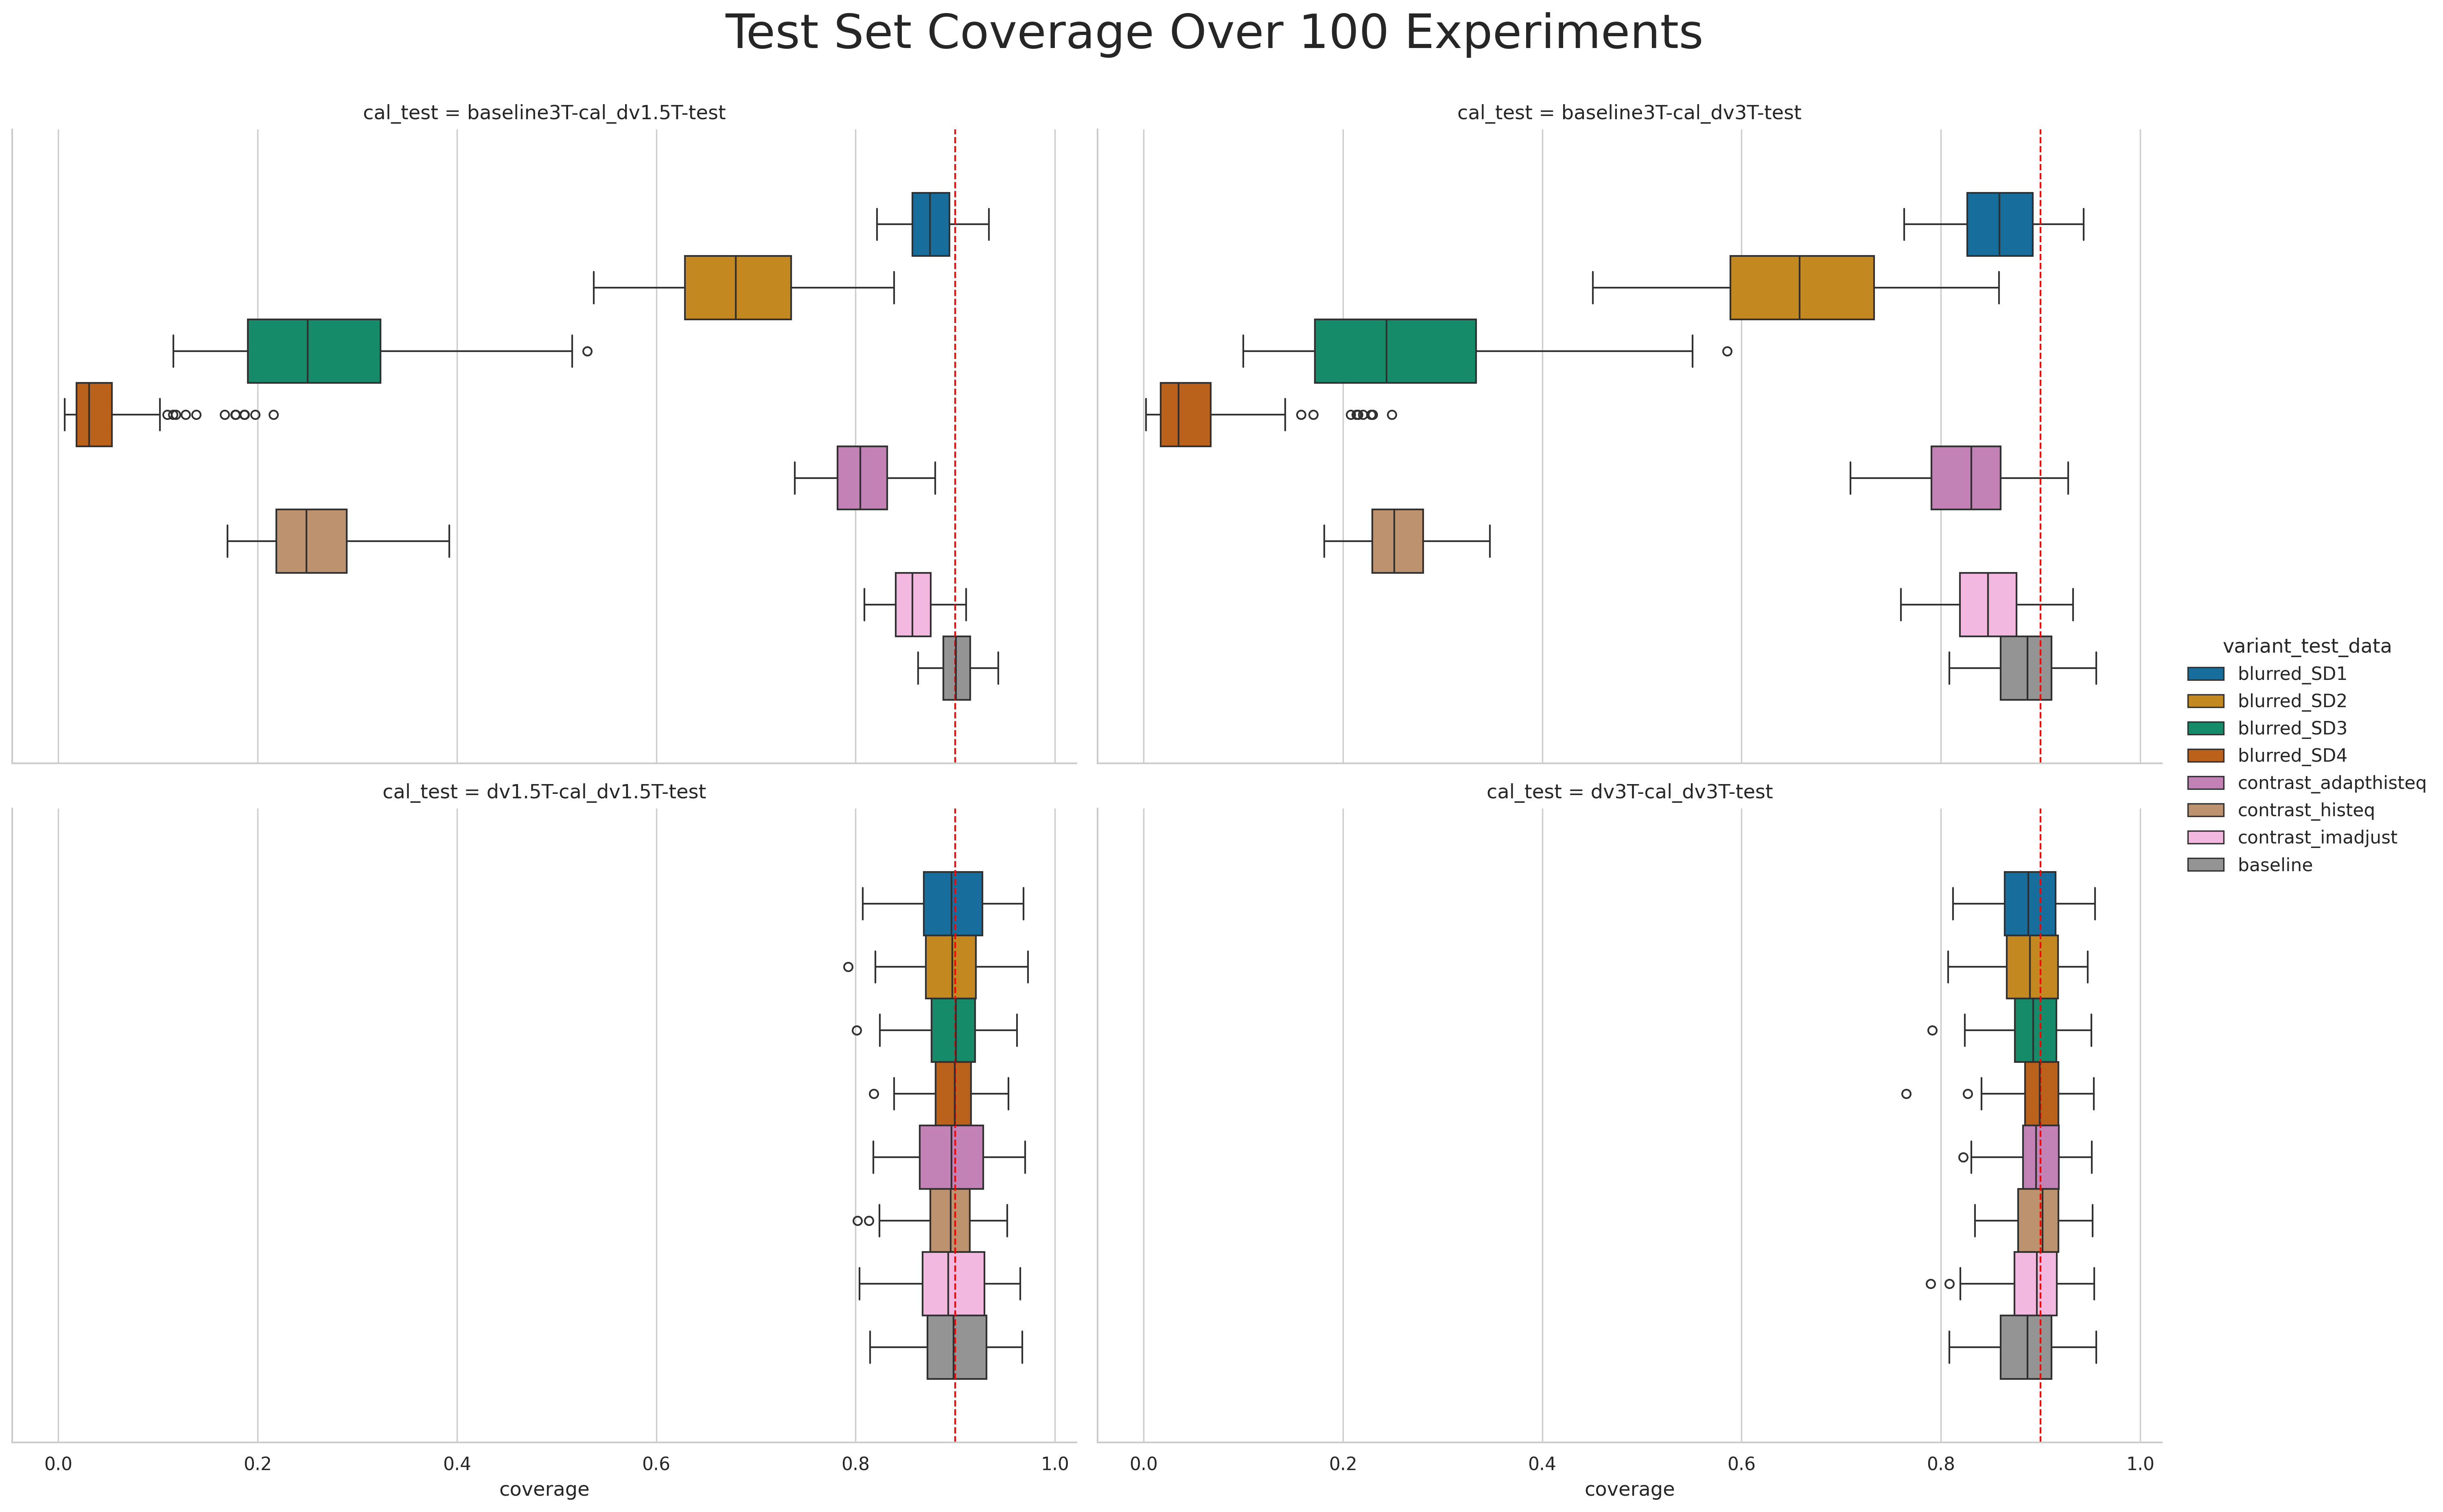

In [3]:
# coverage by class & variant
g = sns.catplot(data=df_runs_scn_lvl, col='cal_test', col_wrap=2, x='coverage', hue='variant_test_data', kind='box', height=6, aspect=1.5)
for ax in g.axes.flatten():
    ax.axvline(0.9, color='red', linestyle='--', linewidth=1)
g.fig.suptitle("Test Set Coverage Over 100 Experiments", y=1.03, fontsize='28')
g.fig.subplots_adjust(top=0.95)

---

---

---

# Experiment Coverage - Primary Pipeline

---

e.g., standard conformal prediction with scan-level statistics

---

---

## Background 

---

### Statistical Testing Framework

The Beta-binomial test evaluates whether observed coverage falls **below** the nominal guarantee, following the framework from our calculation notebook:

- **Null hypothesis (H₀)**: Calibration and test sets are exchangeable with true miscoverage rate α (i.e., coverage ≥ 1-α)
- **Alternative hypothesis (H₁)**: Coverage is less than 1-α (systematic under-coverage)

Under H₀, the number of covered points follows a Beta-binomial distribution with parameters:
- n = number of validation points
- a = (n_cal + 1) - ⌈(n_cal + 1)α⌉ 
- b = ⌈(n_cal + 1)α⌉

The p-value = P(C_j ≤ k_observed | H₀) quantifies how surprising it would be to observe this few or fewer covered points if the conformal guarantee held. Small p-values indicate evidence of systematic under-coverage.

---
---

### Per‑run quantities (computed 100 × per lane)

| symbol in code             | what it is                                            | statistical question it answers                                                                        |
| -------------------------- | ----------------------------------------------------- | ------------------------------------------------------------------------------------------------------ |
| `coverage = n_cov / n_val` | empirical hit‑rate on that split                      | “Did the prediction sets cover the true label in **this** run?”                                        |
| `p_value`                  | one‑sided Beta–binomial tail $P(C_j≤k_{\text{obs}} | H₀)$ | "Under the null hypothesis of valid coverage (≥90%), what is the probability of observing coverage this low or lower?" |

---
---

### Aggregated columns (100 runs per lane)

| column           | how it is formed                         | how to read it                                                             |
| ---------------- | ---------------------------------------- | -------------------------------------------------------------------------- |
| `median_cov`     | median of the 100 per‑run coverages      | the “typical” coverage we attained                                        |
| `median_p`       | median of the 100 p‑values               | typical strength of evidence *against* the coverage guarantee              |
| `q25_p`, `q75_p` | 1st & 3rd quartiles of the p‑values      | spread / skew of the evidence                                              |
| `prop_sig`       | fraction of runs with p < 0.05           | how often the guarantee broke (5 % is what we expect if the null is true) |
| `binom_p`        | exact Binomial test on `prop_sig`        | are failures happening **more than 5 %** of the time?                      |
| `fisher_p`       | Fisher’s χ²₂R combination of all 100 p’s | aggregate evidence; sensitive to even a few extreme runs                   |

---

#### Decision heuristics:

(given α = 0.1 & significance level = 0.05)
  
  - A lane with prop_sig ≈ 0.05, binom_p ≈ 1, fisher_p ≫ 0.05, and median_cov ≈ 0.9 behaves as theory predicts.

  - A lane with prop_sig → 1, binom_p ≪ 0.05, fisher_p ≈ 0, and low median_cov is systematically under‑covered.

> - **Power consideration**: A lane with `prop_sig` ≈ 0.05 and `median_cov` = 0.88 may indicate mild under-coverage that individual runs lack power to detect, but the aggregate pattern reveals through slightly elevated `prop_sig`.
>
> - **Sample size context**: With n_cal = 42, detecting coverage of exactly 85% vs 90% requires observing ≤35 covered samples (83.3%) to achieve p < 0.05 under the Beta-binomial test.

---
---

## Get Statistics

In [4]:
# --- PRIMARY PIPELINE: scan‐level stats, class_conditional == False ---
df = get_stats(df_runs_scn_lvl, df_summary_scn_lvl)

---

## Statistical Power Considerations

### Sample Size Limitations

With only **42 scans** in the calibration set for scan-level analysis, our statistical power to detect coverage violations is inherently limited:

- **Effect size detection**: Small deviations from 90% coverage (e.g., actual coverage of 85-88%) may not be statistically significant due to limited sample size
- **Beta-binomial variance**: With n=42, the expected number of covered samples is 37.8 (90% of 42), but the discrete nature means observing 36 covered (85.7%) or 37 covered (88.1%) may not trigger significance
- **Confidence interval width**: The 95% CI for true coverage with 38/42 covered spans approximately [77%, 96%], highlighting substantial uncertainty

### Implications for Interpretation

When interpreting "non-significant" results (high p-values):
- **Absence of evidence ≠ evidence of absence**: Failure to detect coverage violations doesn't guarantee the procedure is valid
- **Focus on patterns**: Consistent trends across multiple variants provide stronger evidence than individual test results
- **Complement with other metrics**: Class-conditional coverage and prediction set sizes offer additional diagnostic power

### Why 100 Runs Matter

By conducting 100 independent experiments, we partially mitigate the per-run power limitation:
- **Aggregated metrics** (`prop_sig`, `fisher_p`) pool evidence across runs
- **Expected false positive rate**: Under valid coverage, we expect ~5% of runs to show p < 0.05 by chance
- **Systematic violations**: True coverage failures will manifest as `prop_sig` ≫ 0.05

### Scan-level vs Slice-level Trade-offs

Our analysis presents both perspectives:

1. **Scan-level (n_cal = 42)**: Conservative but statistically cleaner
   - Treats each scan as an independent unit
   - Respects within-scan correlations
   - May fail to detect subtle coverage violations

2. **Slice-level (n_cal = 1,806)**: Anti-conservative but more sensitive
   - Assumes all slices are exchangeable (violated in practice)
   - Detects smaller deviations from nominal coverage
   - Type I error rate exceeds nominal level

The true statistical behavior lies between these extremes. We primarily rely on scan-level analysis for valid inference while using slice-level results as a sensitivity check for potential issues.

---

---

## Results - Deployment Contexts

---

---

### 1. Valid - Research Healthcare Setting

#### `dv3T-cal_dv3T-test`

- **Scanner Field Strength:**  
  - **Development**:
    - 3 T (training)
  - **Deployment**
    - 3 T (calibration & test)  
- **Conformal Prediction Assumptions:**  
  - Calibration & test distributions come from **<u>same</u> data variant**
    - Future (test) **patient data <u>matches</u> previously observed** (calibration) data

---

In [5]:
display(style(df.iloc[24:32]))

,class_conditional,cal_test,variant_test_data,median_cov,binom_p,fisher_p,prop_sig,q25_p,median_p,q75_p
24,False,dv3T-cal_dv3T-test,baseline,0.89,1.00,0.84,0.00,0.28,0.48,0.68
25,False,dv3T-cal_dv3T-test,blurred_SD1,0.89,1.00,0.94,0.00,0.31,0.48,0.72
26,False,dv3T-cal_dv3T-test,blurred_SD2,0.89,1.00,0.99,0.00,0.32,0.50,0.74
27,False,dv3T-cal_dv3T-test,blurred_SD3,0.89,0.99,1.00,0.01,0.38,0.53,0.72
28,False,dv3T-cal_dv3T-test,blurred_SD4,0.90,0.99,1.00,0.01,0.46,0.58,0.74
29,False,dv3T-cal_dv3T-test,contrast_adapthisteq,0.90,1.00,1.00,0.00,0.44,0.55,0.74
30,False,dv3T-cal_dv3T-test,contrast_histeq,0.90,1.00,1.00,0.00,0.40,0.60,0.74
31,False,dv3T-cal_dv3T-test,contrast_imadjust,0.90,0.99,1.00,0.01,0.38,0.56,0.73


---
---
---

### 2. Valid - External / Lower-Resource Healthcare Setting

#### `dv1.5T-cal_dv1.5T-test`

- **Scanner Field Strength:**
  - **Development**:
    - 3 T (training only)
  - **Deployment**
    - 1.5 T (calibration & test)  
- **Conformal Prediction Assumptions:**  
  - Calibration & test distributions come from **<u>same</u> data variant**
    - Future (test) **patient data <u>matches</u> previously observed** (calibration) data

---

In [6]:
display(style(df.iloc[16:24]))

,class_conditional,cal_test,variant_test_data,median_cov,binom_p,fisher_p,prop_sig,q25_p,median_p,q75_p
16,False,dv1.5T-cal_dv1.5T-test,baseline,0.90,1.00,1.00,0.00,0.36,0.57,0.84
17,False,dv1.5T-cal_dv1.5T-test,blurred_SD1,0.90,1.00,1.00,0.00,0.34,0.56,0.81
18,False,dv1.5T-cal_dv1.5T-test,blurred_SD2,0.90,0.99,1.00,0.01,0.35,0.56,0.76
19,False,dv1.5T-cal_dv1.5T-test,blurred_SD3,0.90,1.00,1.00,0.00,0.39,0.59,0.76
20,False,dv1.5T-cal_dv1.5T-test,blurred_SD4,0.90,1.00,1.00,0.00,0.42,0.58,0.72
21,False,dv1.5T-cal_dv1.5T-test,contrast_adapthisteq,0.90,1.00,1.00,0.00,0.31,0.56,0.82
22,False,dv1.5T-cal_dv1.5T-test,contrast_histeq,0.90,1.00,1.00,0.00,0.38,0.55,0.71
23,False,dv1.5T-cal_dv1.5T-test,contrast_imadjust,0.89,1.00,1.00,0.00,0.33,0.53,0.83


---
---
---

### 3. Invalid - Research Healthcare Setting

#### `baseline3T-cal_dv3T-test`

- **Scanner Field Strength:** 
  - **Development**:
    - 3 T (training)
  - **Deployment**
    - 3 T (calibration & test)  
- **Conformal Prediction Assumptions:**  
  - Calibration & test distributions come from **<u>different</u> data variant**
    - Future (test) **patient data <u>systematically differs</u> from previously observed** (calibration) data

---

In [7]:
#
# Note: includes control -> where variant_test_data == baseline (calibration and test match)
#
display(style(df.iloc[8:16]))

,class_conditional,cal_test,variant_test_data,median_cov,binom_p,fisher_p,prop_sig,q25_p,median_p,q75_p
8,False,baseline3T-cal_dv3T-test,baseline,0.89,1.00,0.84,0.00,0.28,0.48,0.68
9,False,baseline3T-cal_dv3T-test,blurred_SD1,0.86,0.01,1.1e-05,0.11,0.12,0.28,0.52
10,False,baseline3T-cal_dv3T-test,blurred_SD2,0.66,2.4e-98,0.00,0.87,7.4e-06,2.5e-04,0.01
11,False,baseline3T-cal_dv3T-test,blurred_SD3,0.24,7.9e-131,0.00,1.00,1.0e-24,3.2e-19,2.5e-14
12,False,baseline3T-cal_dv3T-test,blurred_SD4,0.03,7.9e-131,0.00,1.00,5.1e-59,3.7e-49,4.3e-39
13,False,baseline3T-cal_dv3T-test,contrast_adapthisteq,0.83,8.6e-16,0.00,0.30,0.04,0.14,0.28
14,False,baseline3T-cal_dv3T-test,contrast_histeq,0.25,7.9e-131,0.00,1.00,3.5e-20,9.7e-19,5.0e-17
15,False,baseline3T-cal_dv3T-test,contrast_imadjust,0.85,4.3e-03,7.9e-09,0.12,0.10,0.21,0.39


---
---
---

### 4. Invalid - External / Lower-Resource Healthcare Setting

#### `baseline3T-cal_dv1.5T-test`

- **Scanner Field Strength:**
  - **Development**:
    - 3 T (training)
  - **Deployment**
    - <u>3 T (calibration)</u>  
    - 1.5 T (test)  
- **Conformal Prediction Assumptions:**  
  - Calibration & test distributions come from **<u>different</u> scanner field strength**
  - Calibration & test distributions come from **<u>different</u> data variant**
    - Future (test) **patient data <u>systematically differs</u> from previously observed** (calibration) data

---

In [8]:
display(style(df.iloc[:8]))

,class_conditional,cal_test,variant_test_data,median_cov,binom_p,fisher_p,prop_sig,q25_p,median_p,q75_p
0,False,baseline3T-cal_dv1.5T-test,baseline,0.90,1.00,1.00,0.00,0.49,0.59,0.72
1,False,baseline3T-cal_dv1.5T-test,blurred_SD1,0.87,1.00,0.48,0.00,0.26,0.38,0.54
2,False,baseline3T-cal_dv1.5T-test,blurred_SD2,0.68,2.5e-109,0.00,0.92,5.7e-05,6.3e-04,0.01
3,False,baseline3T-cal_dv1.5T-test,blurred_SD3,0.25,7.9e-131,0.00,1.00,2.4e-23,5.9e-19,6.2e-15
4,False,baseline3T-cal_dv1.5T-test,blurred_SD4,0.03,7.9e-131,0.00,1.00,1.1e-60,1.5e-52,1.4e-43
5,False,baseline3T-cal_dv1.5T-test,contrast_adapthisteq,0.80,9.4e-24,0.00,0.38,0.03,0.07,0.14
6,False,baseline3T-cal_dv1.5T-test,contrast_histeq,0.25,7.9e-131,0.00,1.00,4.0e-21,4.8e-19,1.2e-16
7,False,baseline3T-cal_dv1.5T-test,contrast_imadjust,0.86,1.00,4.8e-04,0.00,0.18,0.26,0.39


---

---

## Observations

---

### Expected‑to‑be‑exchangeable pairs  

`dv3T‑cal_dv3T‑test` and `dv1.5T‑cal_dv1.5T‑test` (rows 24–31 and 16–23):

- `median_cov` sits at ~0.90 for almost every variant.
- `prop_sig` ≤ 0.02, `binom_p`≈1, `fisher_p`≈0.8–1.0.

#### Interpretation

The conformal procedure meets its 90% target for both field strengths when calibration and test share the same distribution.

---

---

### Same‑scanner baseline calibration vs degraded 3 T variants

`baseline3T‑cal_dv3T‑test`, rows 8–15:

| variant            | median\_cov | prop\_sig | comment              |
| ------------------ | ----------- | --------- | -------------------- |
| baseline           | ~0.90        | 0.00      | as expected          |
| blurred / contrast | 0.03–0.86   | 0.11–1.00 | heavy under‑coverage |

#### Interpretation  

Using clean baseline scans for calibration does not protect coverage once blur/contrast is applied to the test images.  

In many cases, every split fails the guarantee (`prop_sig`→1, `fisher_p`≈0).

---

---

### Cross‑scanner mismatch (3 T → 1.5 T)

`baseline3T‑cal_dv1.5T‑test`, rows 0–7:  

- medium to severe blur has `prop_sig`≥0.92 and `median_cov`≤0.68;
- severe blur drops coverage to 0.03 with every run significant.

Interestingly, despite cross-scanner mismatch, baseline and mild blur have `median_cov`≥0.87.

#### Interpretation

3 T calibration scores are not transferable to 1.5 T. The guarantee collapses.

---

**Expanded Interpretation**  

These findings suggest that calibration on 3 T data should not be relied upon to extend to 1.5 T acquisitions. 

Under moderate blur, we observed consistently low median coverage (≤ 0.68) and high rates of significance (`prop_sig` ≥ 0.92), with severe blur reducing coverage to near zero across all runs.  

However, the maintenance of relatively high __marginal__ coverage (≥ 0.87) under mild blur and baseline conditions, despite cross-scanner mismatch, implies that the collapse in coverage may not be uniform across all mismatch scenarios.

Taken together, while the results point toward a degradation of conformal guarantees under certain cross-scanner and blur conditions, further work is needed to elucidate the mechanisms driving these outlier cases (__see below__).

---

---

## Addressing outlier cases

The outlier cases that maintain high coverage despite scanner-mismatched and data-variant mismatches reveal important insights that merit closer examination.

First, evaluating empirical coverage against the expected beta-binomial distribution alone may fail to detect subtle exchangeability violations. Although this comparison quantifies how surprising a given coverage level is under ideal conformal assumptions, it does not guarantee identification of every mismatch.

Moreover, coverage by itself is insufficient to assess a conformal predictor’s robustness. Factors such as extreme class imbalance—especially when the classifier favors the majority class—and the underlying model’s performance on the test set can obscure violations of the exchangeability assumption.

Fortunately, complementary diagnostics exist. Class-conditional coverage, prediction-set size analysis, and uncertainty measures like credibility, margin, and confidence provide additional lenses through which to evaluate model soundness. Examining these metrics in a class-stratified manner is particularly valuable when one class dominates predictions, as in our dataset.

In the sections that follow, we will delve into these conformal uncertainty measures.  

__Within the scope of this notebook__, we will focus on the analyses outlined below (see __Figure 1__ and __Figure 2__).

This is followed by an appendix with complete statistics and additional material.

---

### Figure 1

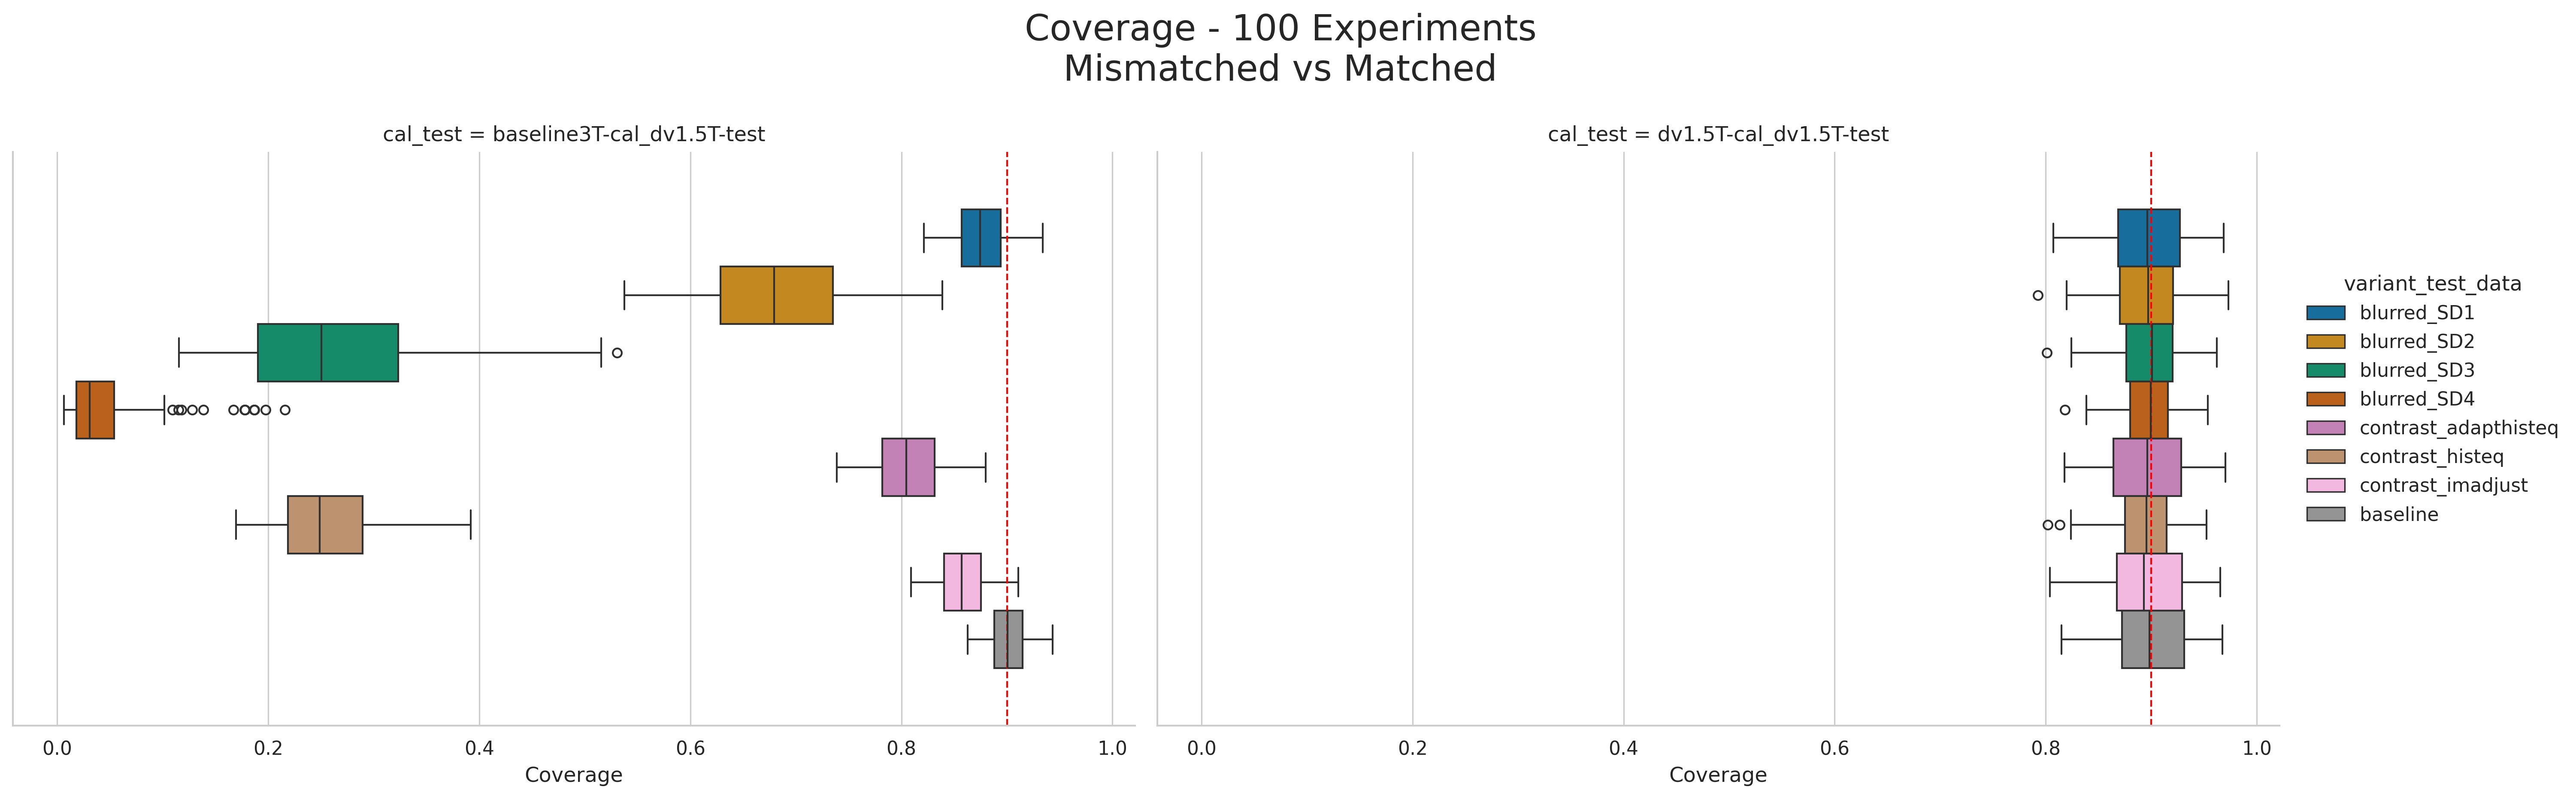

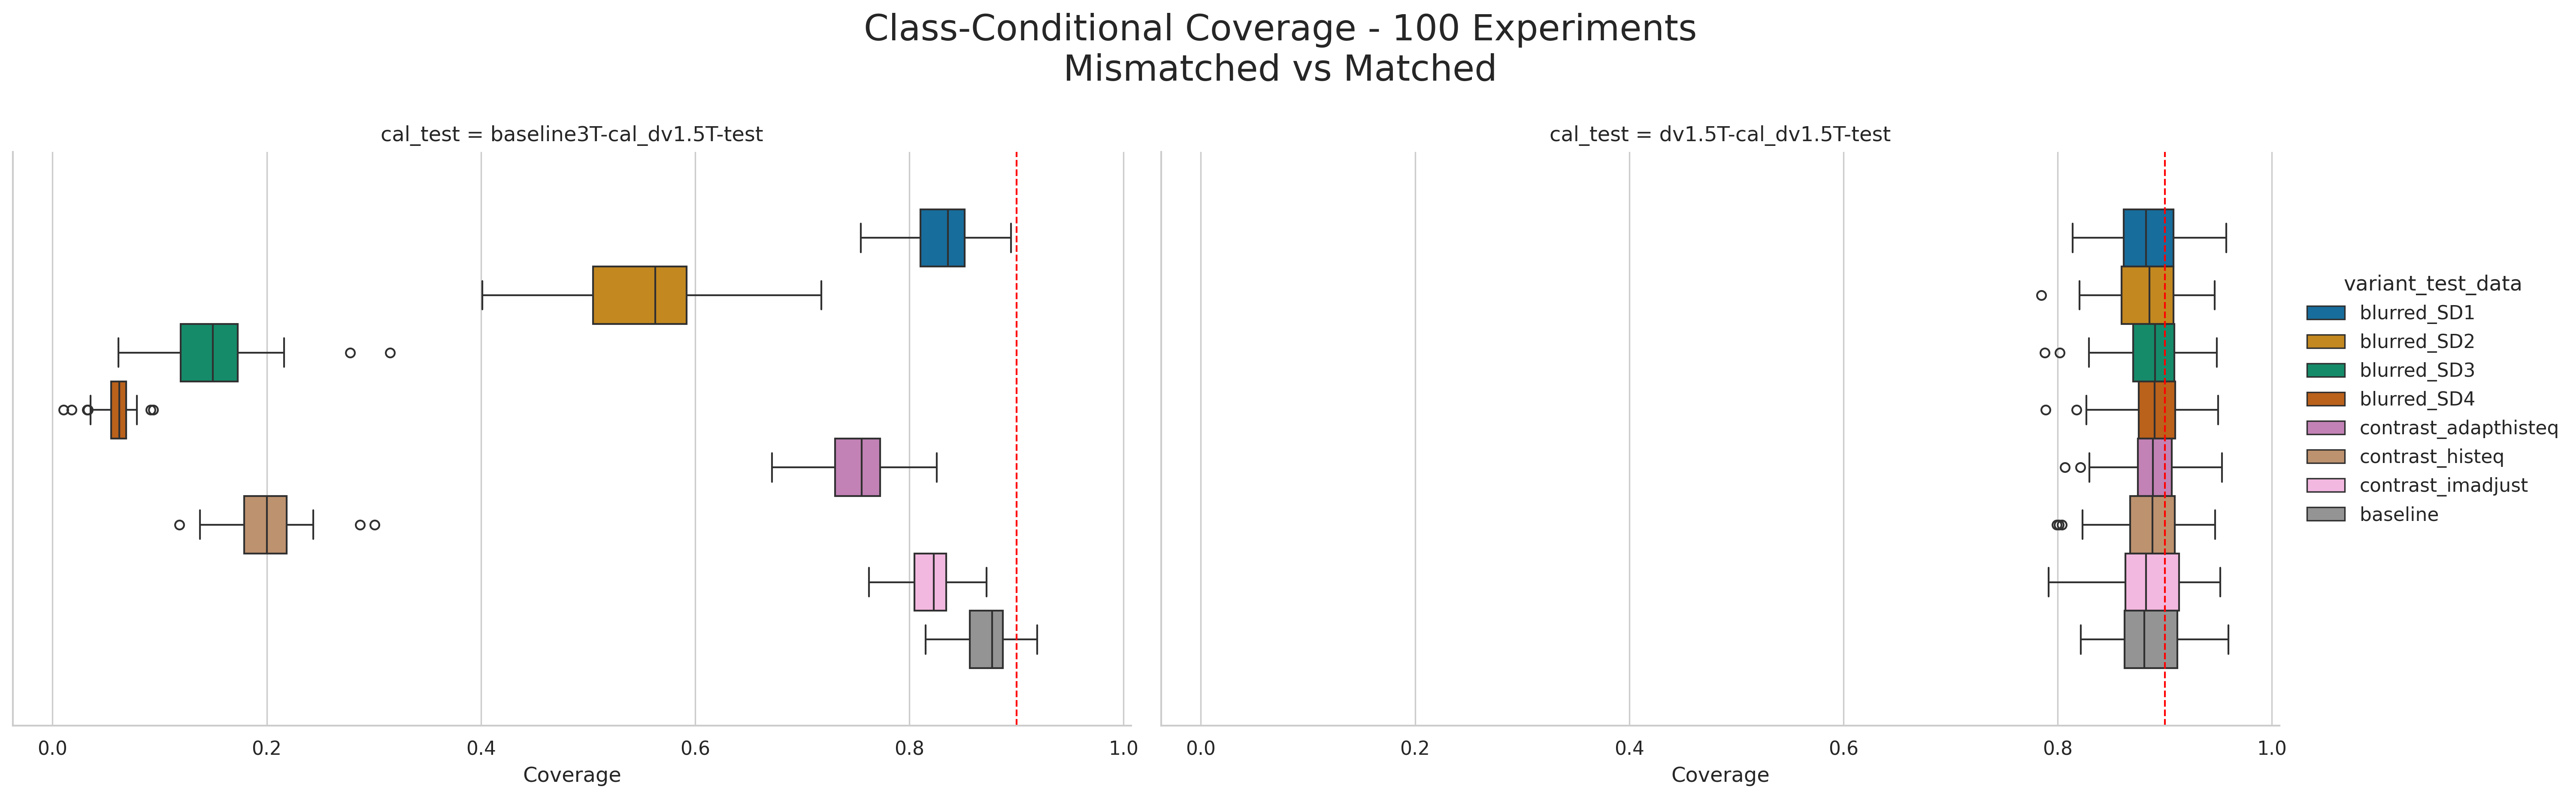

In [9]:
plot_cov()
plot_cc_cov()

In **Figure 1**, the upper panels show overall test‐set coverage for scanner‐mismatched (left) versus correctly distribution‐matched (right) calibration‐test splits. Under the standard (unconditional) split‐conformal procedure, distribution‐matched settings maintain uniformly high coverage across all data variants, whereas scanner‐mismatched baseline and mild‐blur variants still achieve only marginally lower—but still acceptable—coverage. The lower panels apply class‐conditional conformal prediction: here, mismatched configurations (left) suffer a clear decline in coverage, while matched configurations (right) continue to guarantee the nominal coverage level.

---

### Figure 2

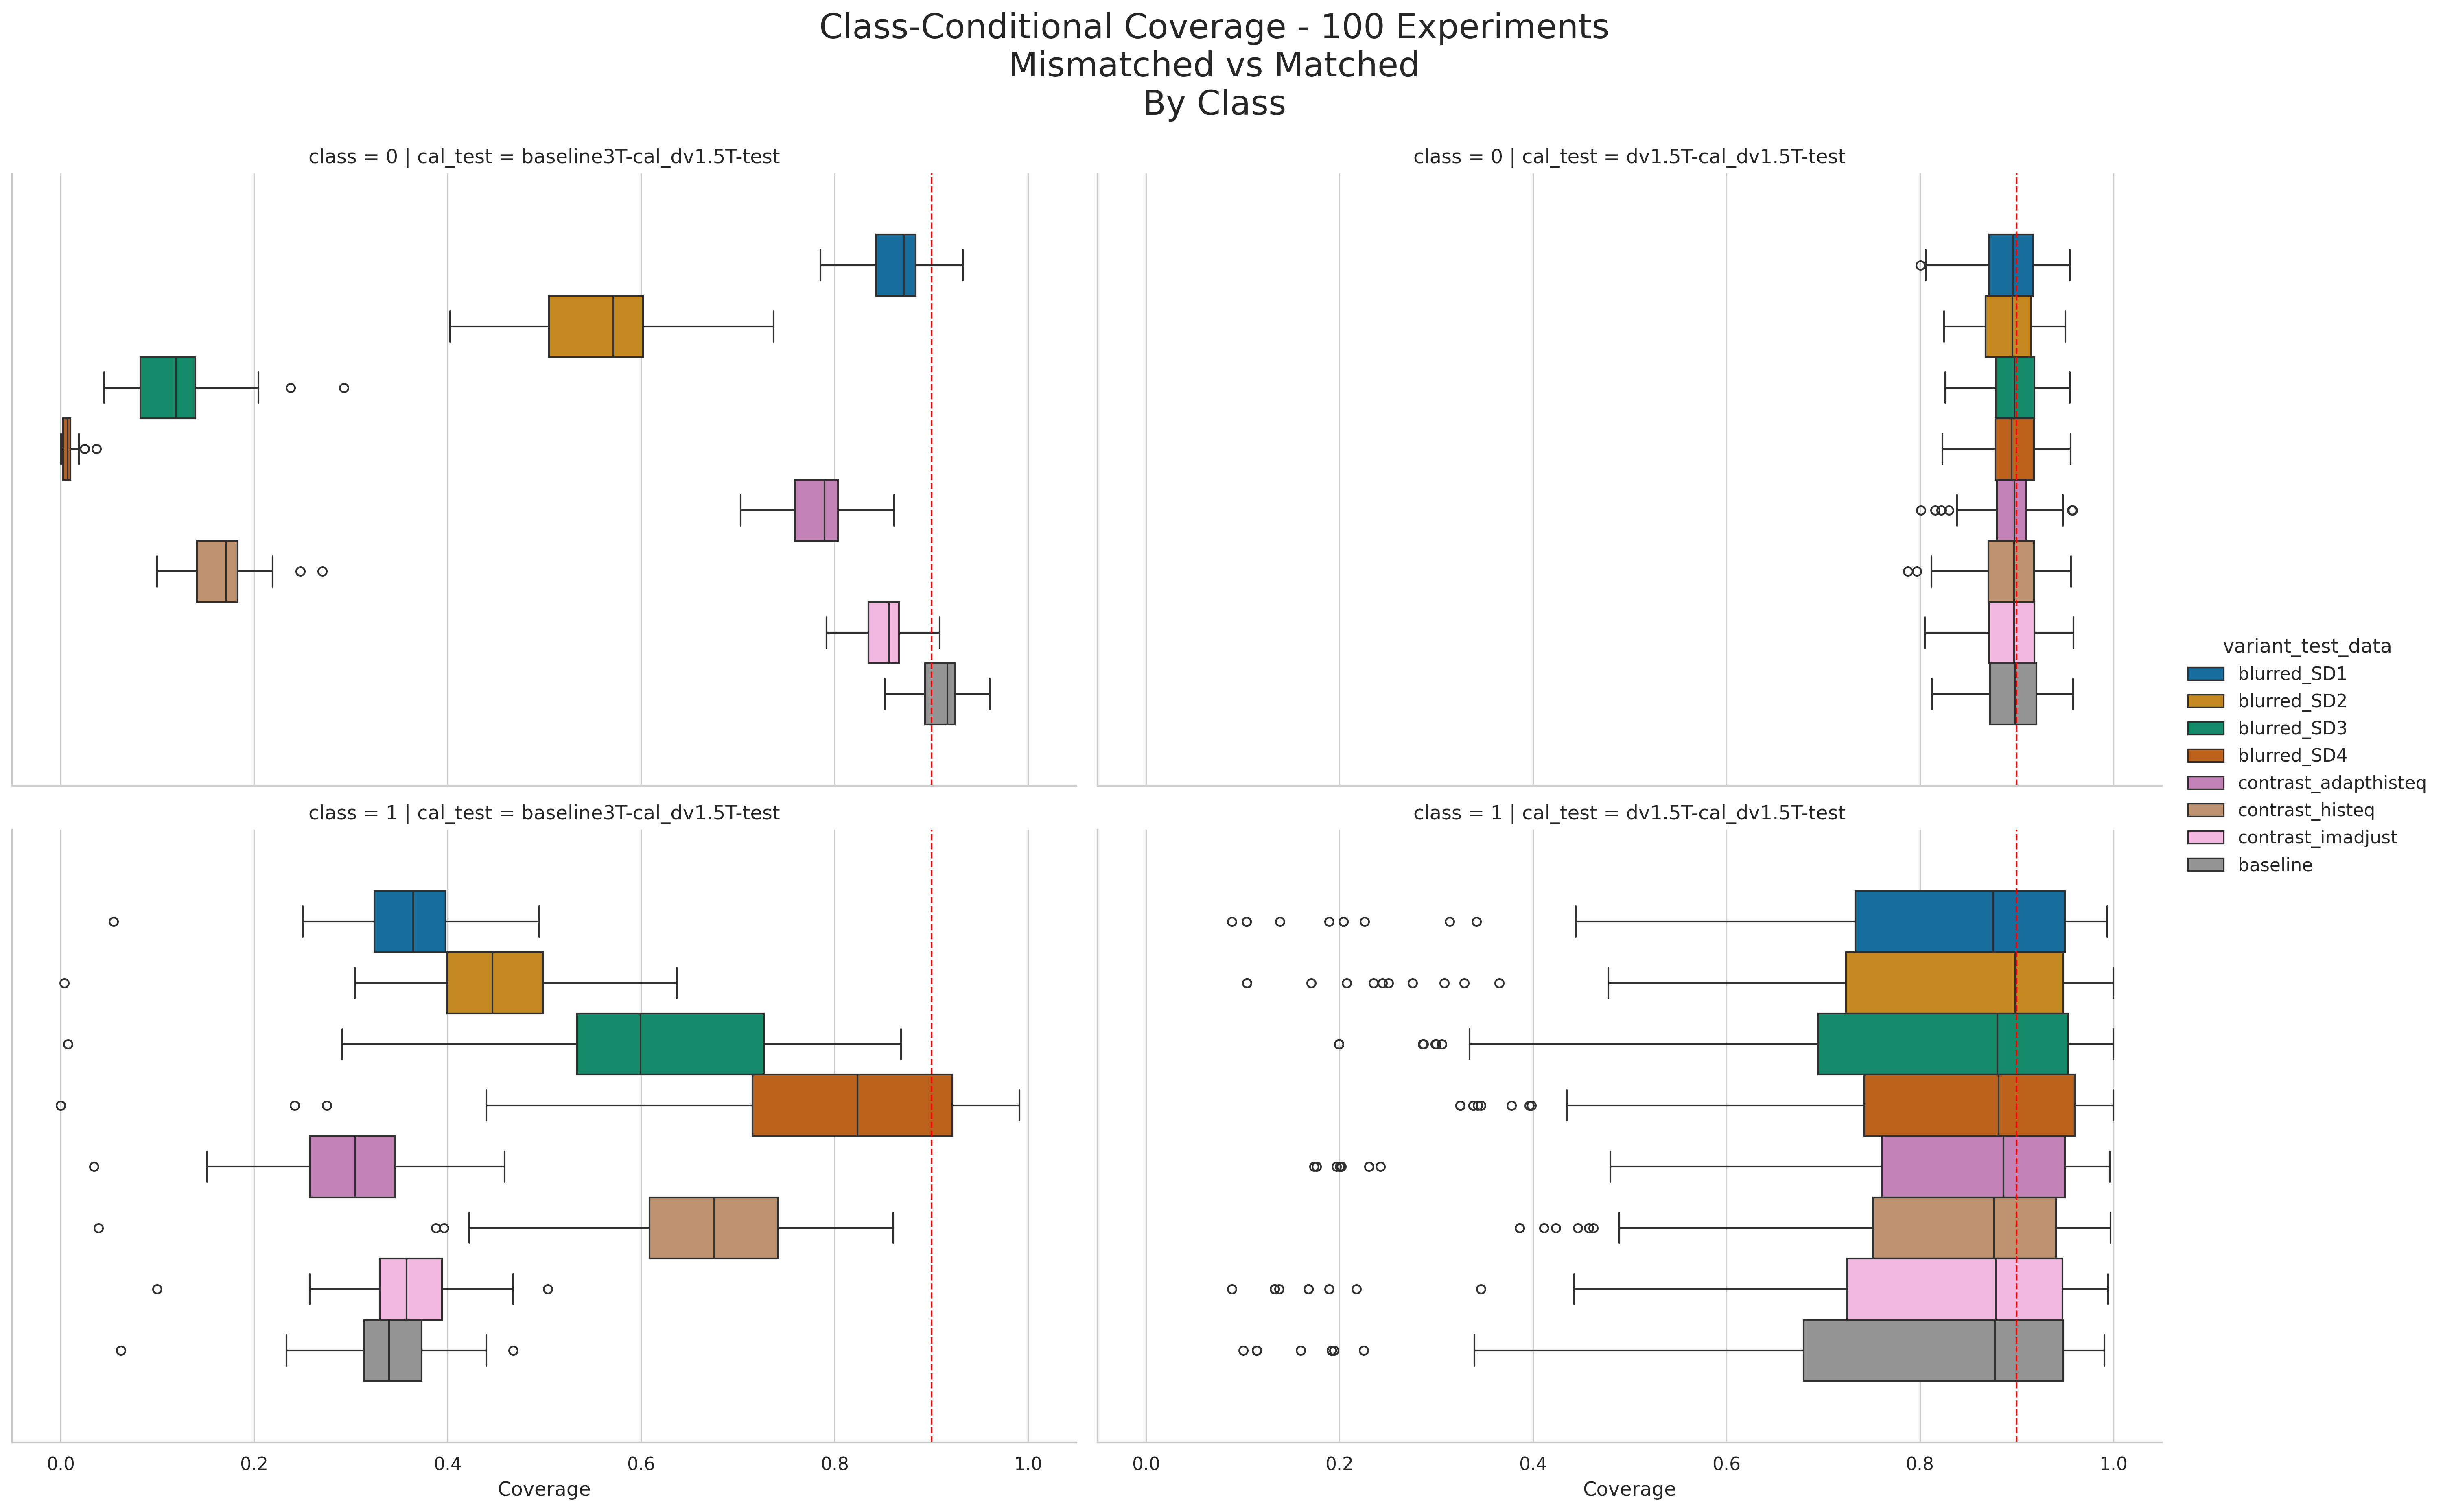

In [10]:
plot_cc_cov_by_class()

In **Figure 2**, we decompose the class‐conditional results by clinical class: healthy controls (class 0, top row) and MS patients (class 1, bottom row), again contrasting mismatched (left) versus matched (right) splits. Most mismatched calibration–test configurations exhibit undercoverage in both classes. Notably, one mismatched variant attains near‐target coverage for healthy controls, and a different variant maintains reasonable coverage for MS patients. On the other hand, distribution‐matched settings maintain uniformly high coverage across all data variants.

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

# Appendix


---

---

## Complete Scan-Level Statistics

In [11]:
summary_1 = df_runs_scn_lvl.groupby(['class_conditional', 'cal_test', 'variant_test_data'])[['coverage']].agg('median')
summary_1 = summary_1.rename(columns={'coverage':'median_cov'})
summary_2 = summary_to_wide(df_summary_scn_lvl).groupby(['class_conditional', 'cal_test', 'variant_test_data']).agg('median')
df = summary_1.merge(summary_2, left_index=True, right_index=True).reset_index()[['class_conditional', 'cal_test', 
                                                                                  'variant_test_data', 'median_cov',
                                                                                  'binom_p', 'fisher_p',
                                                                                  'prop_sig', 'q25_p', 'median_p', 'q75_p']]

display(style(df))

,class_conditional,cal_test,variant_test_data,median_cov,binom_p,fisher_p,prop_sig,q25_p,median_p,q75_p
0,False,baseline3T-cal_dv1.5T-test,baseline,0.90,1.00,1.00,0.00,0.49,0.59,0.72
1,False,baseline3T-cal_dv1.5T-test,blurred_SD1,0.87,1.00,0.48,0.00,0.26,0.38,0.54
2,False,baseline3T-cal_dv1.5T-test,blurred_SD2,0.68,2.5e-109,0.00,0.92,5.7e-05,6.3e-04,0.01
3,False,baseline3T-cal_dv1.5T-test,blurred_SD3,0.25,7.9e-131,0.00,1.00,2.4e-23,5.9e-19,6.2e-15
4,False,baseline3T-cal_dv1.5T-test,blurred_SD4,0.03,7.9e-131,0.00,1.00,1.1e-60,1.5e-52,1.4e-43
5,False,baseline3T-cal_dv1.5T-test,contrast_adapthisteq,0.80,9.4e-24,0.00,0.38,0.03,0.07,0.14
6,False,baseline3T-cal_dv1.5T-test,contrast_histeq,0.25,7.9e-131,0.00,1.00,4.0e-21,4.8e-19,1.2e-16
7,False,baseline3T-cal_dv1.5T-test,contrast_imadjust,0.86,1.00,4.8e-04,0.00,0.18,0.26,0.39
8,False,baseline3T-cal_dv3T-test,baseline,0.89,1.00,0.84,0.00,0.28,0.48,0.68
9,False,baseline3T-cal_dv3T-test,blurred_SD1,0.86,0.01,1.1e-05,0.11,0.12,0.28,0.52


---

### Class-Conditional Statistics

In [3]:
summary_1 = df_runs_scn_lvl_cc.groupby(['class_conditional', 'cal_test', 'variant_test_data', 'class'])[['coverage']].agg('median')
summary_1 = summary_1.rename(columns={'coverage':'median_cov'})
summary_2 = summary_to_wide(df_summary_scn_lvl_cc).groupby(['class_conditional', 'cal_test', 'variant_test_data', 'class']).agg('median')
df = summary_1.merge(summary_2, left_index=True, right_index=True).reset_index()[['class_conditional', 'cal_test', 
                                                                                  'variant_test_data', 'class', 'median_cov',
                                                                                  'binom_p', 'fisher_p',
                                                                                  'prop_sig', 'q25_p', 'median_p', 'q75_p']]

display(style(df))

,class_conditional,cal_test,variant_test_data,class,median_cov,binom_p,fisher_p,prop_sig,q25_p,median_p,q75_p
0,True,baseline3T-cal_dv1.5T-test,baseline,0,0.92,1.00,1.00,0.00,0.47,0.64,0.71
1,True,baseline3T-cal_dv1.5T-test,baseline,1,0.34,4.0e-119,0.00,0.96,4.8e-04,2.6e-03,0.01
2,True,baseline3T-cal_dv1.5T-test,blurred_SD1,0,0.87,0.96,1.3e-04,0.02,0.17,0.31,0.39
3,True,baseline3T-cal_dv1.5T-test,blurred_SD1,1,0.36,4.0e-119,0.00,0.96,7.4e-04,3.3e-03,0.01
4,True,baseline3T-cal_dv1.5T-test,blurred_SD2,0,0.57,7.9e-131,0.00,1.00,1.7e-07,5.2e-06,2.6e-05
5,True,baseline3T-cal_dv1.5T-test,blurred_SD2,1,0.45,2.4e-98,0.00,0.87,2.6e-03,0.01,0.02
6,True,baseline3T-cal_dv1.5T-test,blurred_SD3,0,0.12,7.9e-131,0.00,1.00,6.8e-32,5.8e-28,4.4e-25
7,True,baseline3T-cal_dv1.5T-test,blurred_SD3,1,0.60,3.5e-28,0.00,0.42,0.02,0.06,0.15
8,True,baseline3T-cal_dv1.5T-test,blurred_SD4,0,0.01,7.9e-131,0.00,1.00,1.4e-75,6.2e-67,1.9e-62
9,True,baseline3T-cal_dv1.5T-test,blurred_SD4,1,0.82,1.5e-03,7.2e-08,0.13,0.12,0.34,0.61


---

---

## Complete Slice-Level Statistics

---

### What Changes

---

Because each scan contributes 43 "pseudo-independed" slices:  

- `n_cal` ≈ 1800 rather than 42 → the Beta–binomial tails are much tighter.
  - Therefore all p‑values shrink, pushing `prop_sig` close to 1 and `fisher_p`≈0 even for some lanes that passed at scan‑level.

---

### Implications

---

Slice‑level p‑values treat 1,806 calibration slices as exchangeable and are therefore anti‑conservative.  

Scan‑level p‑values (n = 42) are conservative.  

The true Type‑I error lies between the two.

---

In [13]:
summary_1 = df_runs_slc_lvl.groupby(['class_conditional', 'cal_test', 'variant_test_data'])[['coverage']].agg('median')
summary_1 = summary_1.rename(columns={'coverage':'median_cov'})
summary_2 = summary_to_wide(df_summary_slc_lvl).groupby(['class_conditional', 'cal_test', 'variant_test_data']).agg('median')
df = summary_1.merge(summary_2, left_index=True, right_index=True).reset_index()[['class_conditional', 'cal_test', 
                                                                                  'variant_test_data', 'median_cov',
                                                                                  'binom_p', 'fisher_p',
                                                                                  'prop_sig', 'q25_p', 'median_p', 'q75_p']]

display(style(df))

,class_conditional,cal_test,variant_test_data,median_cov,binom_p,fisher_p,prop_sig,q25_p,median_p,q75_p
0,False,baseline3T-cal_dv1.5T-test,baseline,0.90,6.9e-10,0.00,0.23,0.06,0.53,0.98
1,False,baseline3T-cal_dv1.5T-test,blurred_SD1,0.87,5.1e-59,0.00,0.65,1.0e-07,7.0e-04,0.23
2,False,baseline3T-cal_dv1.5T-test,blurred_SD2,0.68,7.9e-131,0.00,1.00,3.0e-140,2.4e-100,3.0e-62
3,False,baseline3T-cal_dv1.5T-test,blurred_SD3,0.25,7.9e-131,0.00,1.00,0.00,0.00,0.00
4,False,baseline3T-cal_dv1.5T-test,blurred_SD4,0.03,7.9e-131,0.00,1.00,0.00,0.00,0.00
5,False,baseline3T-cal_dv1.5T-test,contrast_adapthisteq,0.80,7.9e-131,0.00,1.00,7.0e-37,2.1e-26,1.4e-15
6,False,baseline3T-cal_dv1.5T-test,contrast_histeq,0.25,7.9e-131,0.00,1.00,0.00,0.00,0.00
7,False,baseline3T-cal_dv1.5T-test,contrast_imadjust,0.86,1.8e-100,0.00,0.88,1.2e-12,9.6e-08,9.5e-04
8,False,baseline3T-cal_dv3T-test,baseline,0.89,4.2e-34,0.00,0.47,6.7e-06,0.07,0.91
9,False,baseline3T-cal_dv3T-test,blurred_SD1,0.86,5.5e-67,0.00,0.70,2.0e-14,3.8e-06,0.18


---

### Class-Conditional Statistics

In [4]:
summary_1 = df_runs_slc_lvl_cc.groupby(['class_conditional', 'cal_test', 'variant_test_data', 'class'])[['coverage']].agg('median')
summary_1 = summary_1.rename(columns={'coverage':'median_cov'})
summary_2 = summary_to_wide(df_summary_slc_lvl_cc).groupby(['class_conditional', 'cal_test', 'variant_test_data', 'class']).agg('median')
df = summary_1.merge(summary_2, left_index=True, right_index=True).reset_index()[['class_conditional', 'cal_test', 
                                                                                  'variant_test_data', 'class', 'median_cov',
                                                                                  'binom_p', 'fisher_p',
                                                                                  'prop_sig', 'q25_p', 'median_p', 'q75_p']]

display(style(df))

,class_conditional,cal_test,variant_test_data,class,median_cov,binom_p,fisher_p,prop_sig,q25_p,median_p,q75_p
0,True,baseline3T-cal_dv1.5T-test,baseline,0,0.92,5.0e-07,1.4e-08,0.19,0.22,0.98,1.00
1,True,baseline3T-cal_dv1.5T-test,baseline,1,0.34,7.9e-131,0.00,1.00,1.4e-76,8.5e-61,4.5e-52
2,True,baseline3T-cal_dv1.5T-test,blurred_SD1,0,0.87,1.6e-84,0.00,0.80,2.4e-10,6.3e-04,0.03
3,True,baseline3T-cal_dv1.5T-test,blurred_SD1,1,0.36,7.9e-131,0.00,1.00,3.7e-73,5.8e-57,9.6e-49
4,True,baseline3T-cal_dv1.5T-test,blurred_SD2,0,0.57,7.9e-131,0.00,1.00,7.4e-226,6.0e-164,4.8e-145
5,True,baseline3T-cal_dv1.5T-test,blurred_SD2,1,0.45,7.9e-131,0.00,1.00,1.1e-55,1.5e-42,8.3e-33
6,True,baseline3T-cal_dv1.5T-test,blurred_SD3,0,0.12,7.9e-131,0.00,1.00,0.00,0.00,0.00
7,True,baseline3T-cal_dv1.5T-test,blurred_SD3,1,0.60,1.5e-127,0.00,0.99,2.6e-34,6.2e-22,8.5e-11
8,True,baseline3T-cal_dv1.5T-test,blurred_SD4,0,0.01,7.9e-131,0.00,1.00,0.00,0.00,0.00
9,True,baseline3T-cal_dv1.5T-test,blurred_SD4,1,0.82,1.2e-48,0.00,0.58,7.9e-12,1.5e-03,0.86


---

---

---

---

---

---

---

---

---

## Impact of Calibration Set Size on Empirical Coverage Distribution

**Key Takeaway:**  
Calibration set size directly governs the variability of conformal coverage. In the class-conditional conformal prediction exemplar shown below, each class’s nonconformity scores are calibrated separately—resulting in different effective calibration set sizes per class. Smaller calibration samples yield wider prediction intervals and increased coverage variance, illustrating how calibration set size alone can drive empirical coverage behavior.


---

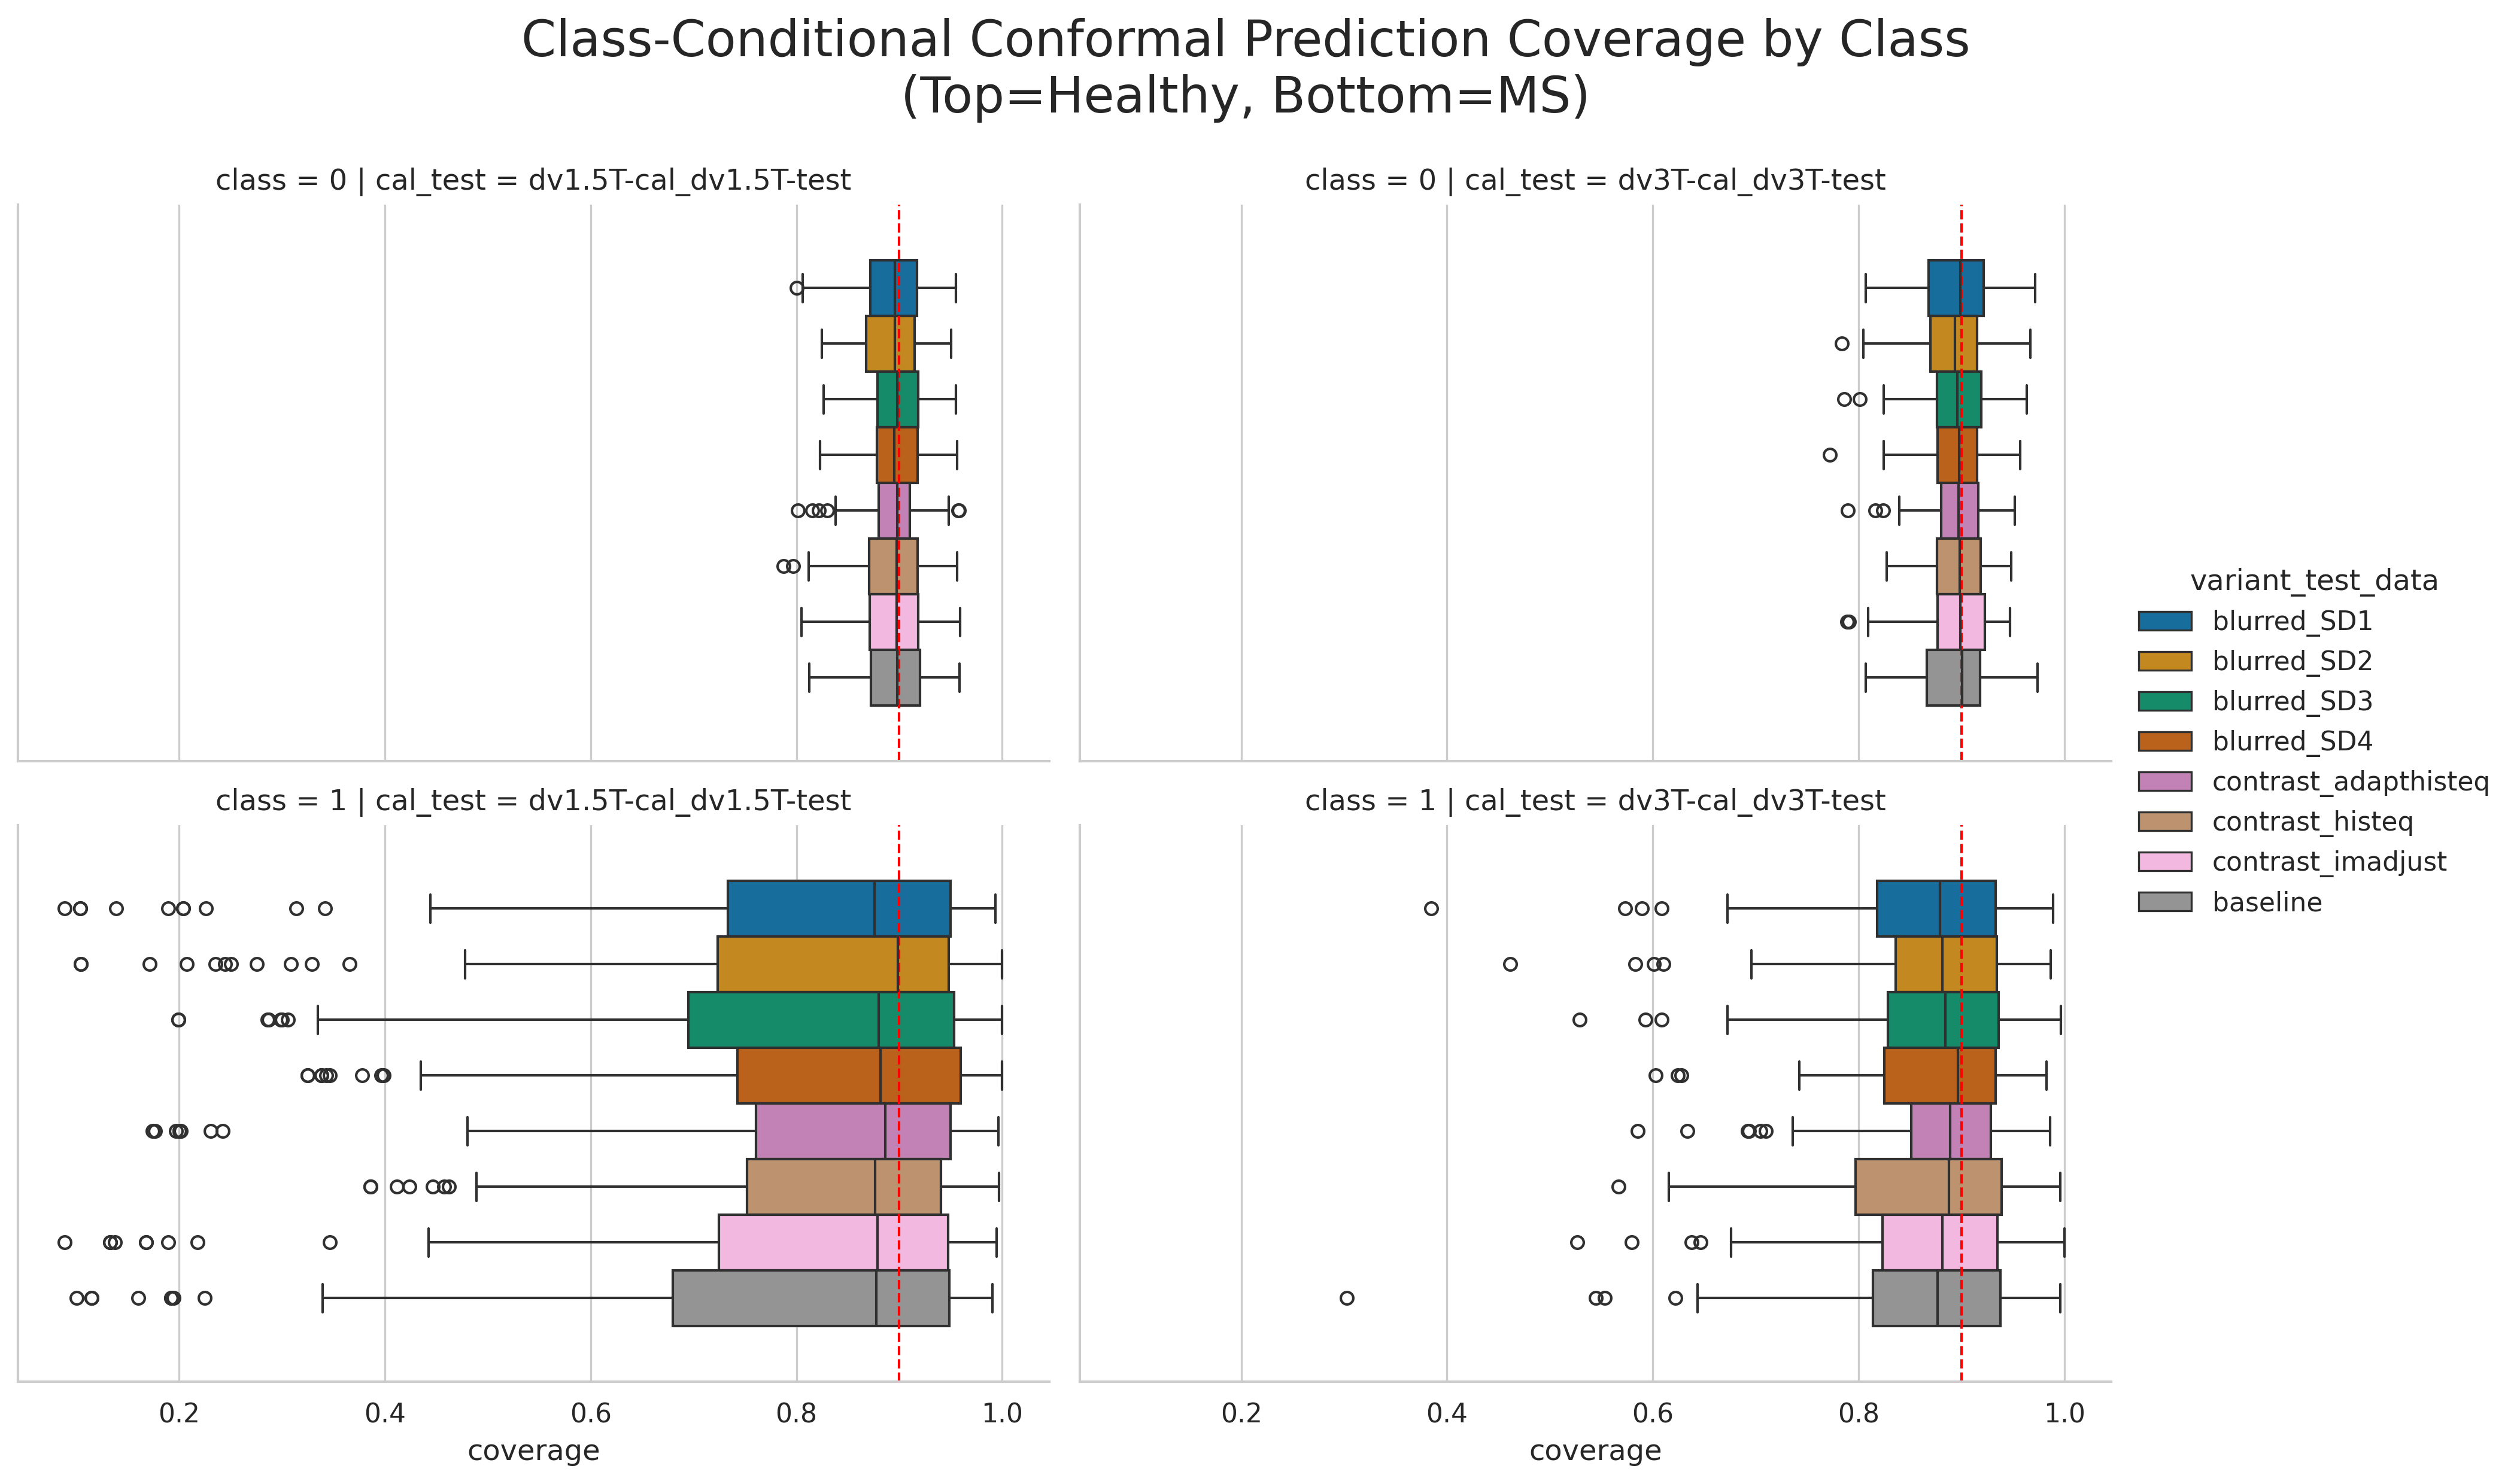

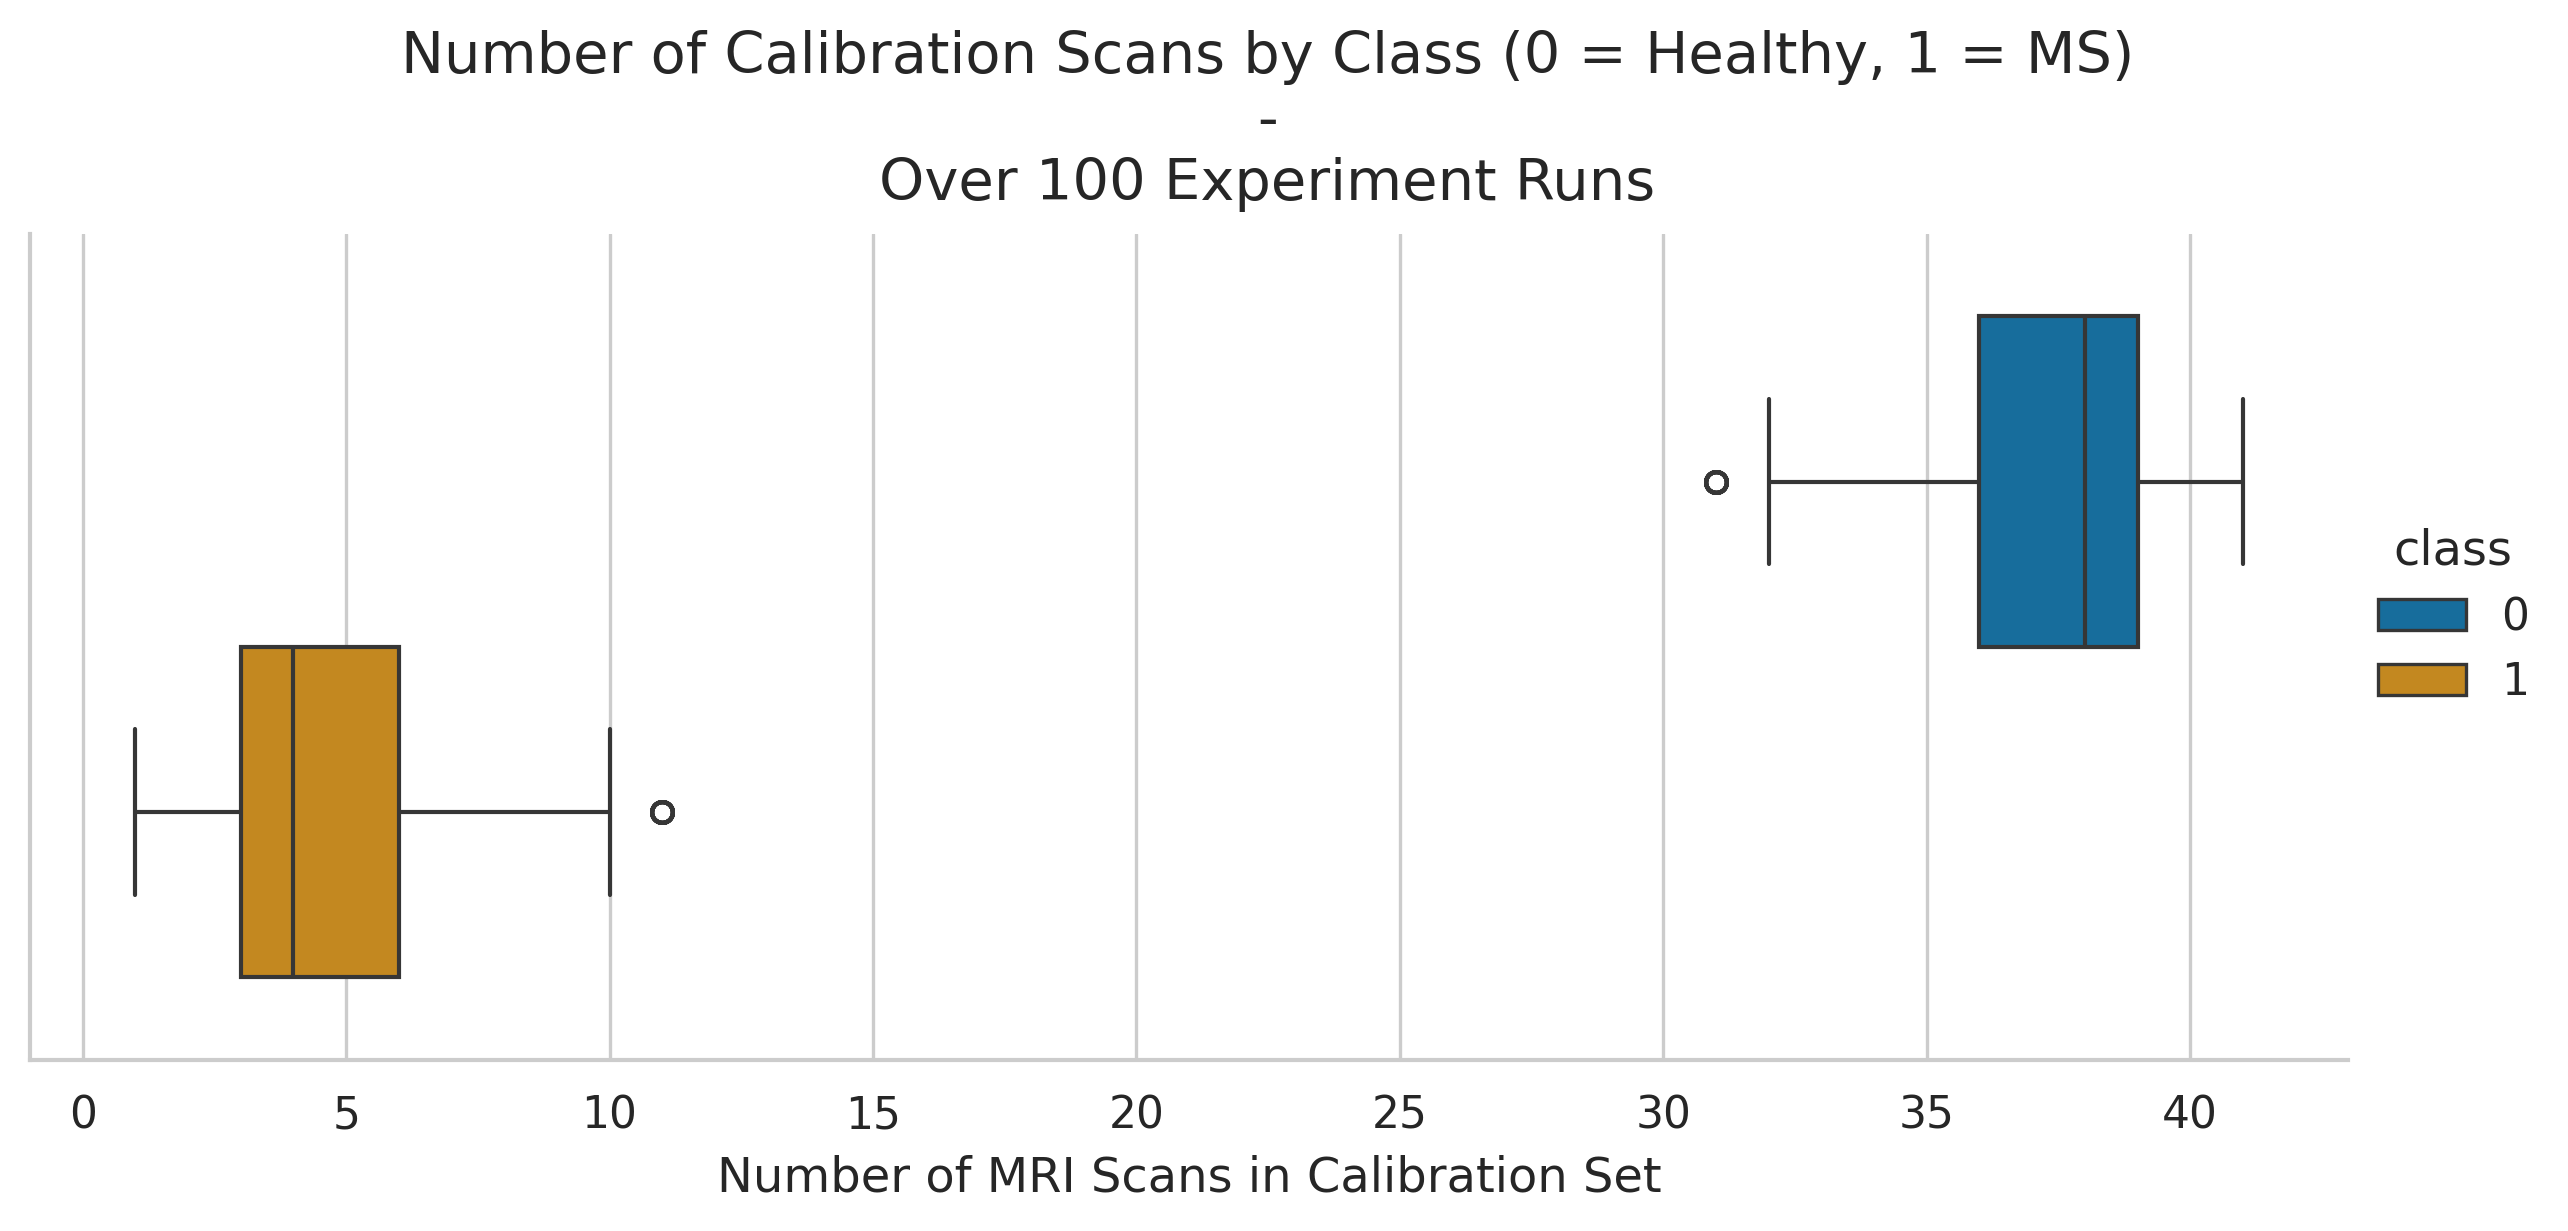

In [15]:
# exclude setups designed to violate assumptions, as that is not the focus here
df_cc = df_runs_scn_lvl_cc[~df_runs_scn_lvl_cc['cal_test'].str.contains('baseline')]
# coverage by class & variant
g1 = sns.catplot(data=df_cc, row='class', col='cal_test', x='coverage', hue='variant_test_data', kind='box', height=4, aspect=1.5)
for ax in g1.axes.flatten():
    ax.axvline(0.9, color='red', linestyle='--', linewidth=1)
g1.fig.suptitle("Class-Conditional Conformal Prediction Coverage by Class\n(Top=Healthy, Bottom=MS)", y=1.03, fontsize='20')
g1.fig.subplots_adjust(top=0.90)
# distribution of n_cal_cls
g2 = sns.catplot(data=df_cc, x='n_cal_cls', hue='class', kind='box', height=4, aspect=2)
g2.set_axis_labels("Number of MRI Scans in Calibration Set", "")
g2.fig.suptitle("Number of Calibration Scans by Class (0 = Healthy, 1 = MS)\n-\nOver 100 Experiment Runs", y=1.02)
g2.fig.subplots_adjust(top=0.85)
plt.show()

---

---

---

---

---

---

---